# [Introduction to Sentinel 2](http://geoscienceaustralia.github.io/digitalearthau/notebooks/02_DEA_datasets/Introduction_to_Sentinel2.html)

### What does this notebook do? 

This notebook steps you through how to load in and plot up data from Sentinel 2. It explores the data that are available from the Sentinel 2 satellite, and briefly describes the Sentinel satellite bands. It then loads in the `s2a_ard_granule` product and plots it up in true and false colour. It uses the provided pixel quality data to filters the example scene based on cloud and cloud shadow-free pixels.


###### Specifics

- Converting a DEA notebook example to use GSKY instaed of datacube.

- Uses WCS to get an area from a specified layer/date/bbox/time, and differs from the DEA example.

- Only one time slice can be used in WCS. 
    - You can choose from all available times in the layer.
    - Only 2 time slices have valid BBoxes hard coded. 
    - The fourth time uses the whole of Australia.

- If you can determine a valid BBox for a date (Tip: Use TerriaMap) it can be manually typed in.

- The DEA example, using datacube, can get the data for a time range. It is not possible in GSKY.

**Author:** Arapaut V. Sivaprasad

**Date:** 24 October, 2019

In [34]:
##########################################################
# Author: Arapaut V. Sivaprasad.                         #
# Dates: Created: 23/10/2019; Last Modified: 24/10/2019  #
##########################################################
import sys
import os

# GSKY-specific imports
from owslib.wcs import WebCoverageService
from random import randrange
import xarray as xr
%matplotlib inline

In [35]:
# Specify the GSKY production URL here. The layer is hard coded
gsky_url = 'http://130.56.242.15/ows/ipynb'
wcs = WebCoverageService(gsky_url, version='1.0.0')
layer = "sentinel2_nbart_daily"

# Uncomment below to see all layers.

#for layer in list(wcs.contents):
#    print ("Layer Name:", layer)
#    print ("Title:", wcs[layer].title, '\n')
    
#wcs.contents['landsat8_nbar_16day']
wcs.contents
#wcs[layer]

{'sentinel2_nbart_daily': <owslib.coverage.wcs100.ContentMetadata at 0x16828db5148>,
 'landsat8_nbar_16day': <owslib.coverage.wcs100.ContentMetadata at 0x1682a4c6a88>}

In [36]:
# To display the available time slices in any range, specify the start and end values as m,n below
time = wcs[layer].timepositions
n_times = len(time)
m = 0
n = n_times
#print ("Total of", n_times,'timepositions:\n\n', time[m:n])

# Unlike in the case of datacube, where a time range can be specified, GSKY requires a specific date.
# This specific time slice is specified below. 
t = n_times-1
wcs[layer].timepositions[t]

'2019-07-21T00:00:00.000Z'

In [37]:
tiles_list = {}
with open("Scripts/tiles_bboxes_out.txt") as f:
    for line in f:
        (key, val) = line.split()
        tiles_list[str(key)] = val

# Uncomment below to see all tiles and ther BBoxes
#tiles_list

In [38]:
# Give two tiles as [top left corner, bottom right corner]
#tiles = ['9_-36','10_-37'] # https://gsky.nci.org.au/ows/dea - Prod GSKY server
tiles = ['8_-32','9_-33']  # http://130.56.242.15/ows/ipynb   - Dev GSKY server
bbox = [tiles_list[tiles[0]],tiles_list[tiles[1]]]

# If you know another BBox containing data (Tip: use TerriaMap to find out) then type it in below.
#bbox = ['130.00,-27.00,131.00,-29.00']

x = float(bbox[0][0:6])
y = float(bbox[0][7:13])
X = float(bbox[1][14:20])
Y = float(bbox[1][21:27])

# The longitude dimension is adjusted to fit the plot size of 337*220 pixels
X = float('%.2f'%(x + ((abs(Y - y) / 220) * 337)))
bbox = (x,y,X,Y)
bbox

(140.26, -28.25, 142.99, -30.03)

In [39]:
# Construct the URL for a WCS call and send it to the GSKY server.
# Style can be False Color (fc) or True Color (tc)
# On the dev GSKY server a style of 'tfc' will give five bands (R,G,B,nir,swir) 
# This NB uses only NetCDF and EPSG:4326. Hence, do not change these.
# If any error, the displayed URL can be opened in a browser to see the actual error message.
output = wcs.getCoverage(identifier=layer, Styles='tfc',
                         time=[wcs[layer].timepositions[t]],
                         bbox=bbox,format='NetCDF',
                         crs='EPSG:4326', width=256, height=256)
print(output.geturl())

http://130.56.242.15/ows/ipynb?version=1.0.0&request=GetCoverage&service=WCS&Coverage=sentinel2_nbart_daily&BBox=140.26%2C-28.25%2C142.99%2C-30.03&time=2019-07-21T00%3A00%3A00.000Z&crs=EPSG%3A4326&format=NetCDF&width=256&height=256&Styles=tfc


In [40]:
# Get the output data from GSKY and write it in a *.nc file
# A random number is inserted in the filename to prevent the browser caching the file content.
rand = str(randrange(100000))
ncfile = './output/gsky_wcs_' + rand + '.nc'
with open(ncfile, 'wb') as f:
    f.write(output.read())

# Sentinel 2 bands

Sentinel 2 satellites have 13 spectral channels. 


<img src='images/sentinel2_bands.png' width="600">


Though the data from datacube returns all the above bands, the GSKY server can return only those specified in '*config.json*' for a namespace (e.g. 'dea'). The production server is set to send only the "*red,green,blue*" as true colors and "*nir,swir*" as false colors. 

On this page we are plotting the false color bands as well. For this, the development server has a special '*ipynb/config.json*' that has a '*style=tfc*'. Choose this style to get all following bands. The band numbers returend by GSKY are as follows, and differ from the table above.

    1. nbart_red
    2. nbart_green
    3. nbart_blue
    4. nbart_nir_1
    5. nbart_nir_2
    6. nbart_swir_2
    7. nbart_swir_3
    8. nbart_coastal_aerosol
    9. nbart_red_edge_1
    10. nbart_red_edge_2
    11. nbart_red_edge_3

These bands cover the visible, near-infrared and short-wave infrared wave lengths.

<img src='images/Sentinel2_Spectral_Bands.jpg' width="600">


# Read the data from the saved file

The data retrieved from GSKY is stored as NetCDF. Read the file and convert the data into Xarray dataset so that it can be plotted and manipulated. The temporary NetCDF file is then deleted.

In [41]:
# Read the NetCDF file and convert it into an xarray dataset
sentinel2_ds = xr.open_dataset(ncfile)

# Delete the created NetCDF file
try:
    os.remove(ncfile)
except OSError:
    pass

# View the raw data

View the data in Xarray format.

In [42]:
# Uncomment below to see the raw data
sentinel2_ds

<xarray.Dataset>
Dimensions:  (lat: 256, lon: 256)
Coordinates:
  * lat      (lat) float64 -28.25 -28.26 -28.27 -28.27 ... -30.01 -30.02 -30.03
  * lon      (lon) float64 140.3 140.3 140.3 140.3 ... 143.0 143.0 143.0 143.0
Data variables:
    Band1    (lat, lon) float32 ...
    Band2    (lat, lon) float32 ...
    Band3    (lat, lon) float32 ...
    Band4    (lat, lon) float32 ...
    Band5    (lat, lon) float32 ...
    Band6    (lat, lon) float32 ...
    Band7    (lat, lon) float32 ...
    Band8    (lat, lon) float32 ...
    Band9    (lat, lon) float32 ...
    Band10   (lat, lon) float32 ...
    Band11   (lat, lon) float32 ...
    crs      |S1 ...
Attributes:
    Conventions:  CF-1.5
    GDAL:         GDAL 2.3.1, released 2018/06/22
    history:      Thu Oct 24 14:12:49 2019: GDAL Create( /tmp/raster_45403864...

# Plot the data

The data returned by GSKY server (Production version) contains only three bands. Depending on the chosen style ('tc' or 'fc') it will be the visible (red, green, blue) or invisible (nir, swir) spectrum. To get all these bands it is necessary to set the GSKY config (config.json) to include all available bands in the NetCDF output.

The various spectral bands are plotted below.

## Plot as a true colour image

True colour images approximate what the human eye sees when looking at a landscape. Note that the function used for this true colour plot enhances the contrast between the bands, resulting in a colour-enhanced image.

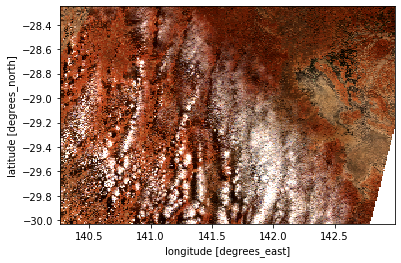

In [43]:
# Plot the first three bands available in the dataset on Prod and Dev servers.
# red, green, blue
sentinel2_ds[['Band1', 'Band2', 'Band3']].to_array().plot.imshow(robust=True) 

## Plot as a false colour image

This plot uses the SWIR, NIR and green bands to accentuate the presence of water in the landscape.

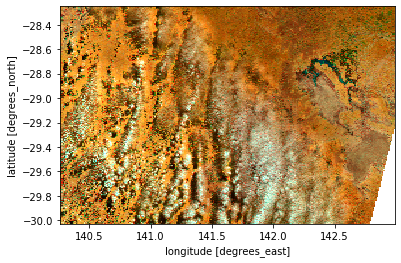

In [44]:
# Additional bands on http://130.56.242.15/ows/ipynb   - Dev GSKY server
# nbart_swir_2, nbart_nir_1, nbart_green 
sentinel2_ds[['Band6', 'Band4', 'Band2']].to_array().plot.imshow(robust=True) 

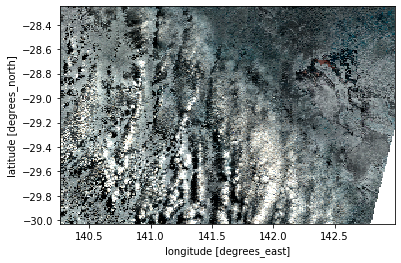

In [45]:
# Additional bands on http://130.56.242.15/ows/ipynb   - Dev GSKY server
# nbart_red_edge_1, nbart_red_edge_2, nbart_red_edge_3
sentinel2_ds[['Band9', 'Band10', 'Band11']].to_array().plot.imshow(robust=True) 

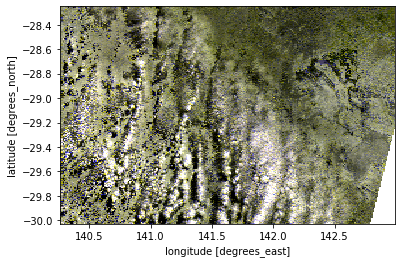

In [46]:
# Additional bands on http://130.56.242.15/ows/ipynb   - Dev GSKY server
# nbart_red_edge_2, nbart_red_edge_3, nbart_red
sentinel2_ds[['Band10', 'Band11', 'Band1']].to_array().plot.imshow(robust=True) 

#### Acknowledgements

This notebook page is derived from this [DEA notebook](http://geoscienceaustralia.github.io/digitalearthau/notebooks/02_DEA_datasets/Introduction_to_Sentinel2.html) and extensively changed to use GSKY server. Some of the text used here are directly copied from the DEA page.